In [1]:
import numpy as np
import time,os
from io import StringIO
np.set_printoptions(linewidth=160)
from PyGT import ktn_io as kio
from PyGT import gt_tools as gt
from scipy.sparse import save_npz, load_npz, diags, eye
from scipy.sparse.linalg import eigs,inv,spsolve
from scipy.sparse.csgraph import connected_components
import scipy as sp
import scipy.linalg as spla
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd

Using tqdm package for pretty progress bars!


In [4]:
""" Calculate kSS, kNSS, kF, k*, kQSD, MFPT, and committors for the transition path
ensemble AS --> BS from rate matrix K. K can be the matrix of an original network,
or a partially -transformed matrix. 

Differs from compute_passage_stats in that this function removes all intervening states
using GT before computing fpt stats and rates on the fully reduced network
with state space (A U B)."""

beta = 1./0.1
B, K, D, N, u, s, Emin, index_sel = kio.load_ktn(path='KTN_data/LJ38/4k/',beta=beta,Emax=None,
                                                 Nmax=None,screen=False)
D = np.ravel(K.sum(axis=0))
BF = beta*u-s
BF -= BF.min()
AS,BS = kio.load_ktn_AB('KTN_data/LJ38/4k/',index_sel)    
IS = np.zeros(N, bool)
IS[~(AS+BS)] = True

D = np.ravel(K.sum(axis=0))
inter_region = ~(AS+BS)
r_AS = AS[~inter_region]
r_BS = BS[~inter_region]
r_BF = BF[~inter_region]
rDSS = D[~inter_region]
#use GT to renormalize away all I states
rB, rtau, rQ = gt.GT(rm_vec=inter_region,B=B,tau=1.0/D,rates=True,block=1)
rD, rN = 1.0 /rtau, rtau.size
#first do A->B direction, so that r_AS is non-absorbing region and r_BS is aborbing
df = pd.DataFrame(columns=['MFPTBA', 'kSSBA', 'kNSSBA', 'kQSDBA', 'k*BA', 'kFBA'])
#eigendecomposition of rate matrix in non-abosrbing region
#for A, rQ[r_A, :][:, r_A] is just a 5x5 matrix
l, w, v = spla.eig(rQ[r_AS,:][:,r_AS].todense(), left=True)
#order the eigenvalues from smallest to largest -- they are positive since Q = D - K instead of K-D
qsdo = np.abs(l.real).argsort()
nu = l.real[qsdo]
#local equilibrium distribution in r_AS
rho = np.exp(-r_BF[r_AS])
rho /= rho.sum()
#v[:, qsdo[0]] is the eigenvector corresponding to smallest eigenvalue
#aka quasi=stationary distribution
qsd = v[:,qsdo[0]]
print(qsd)
qsd /= qsd.sum()

#committor C^B_A: probability of reaching B before A: 1_B.B_BA^I (eqn 6 of SwinburneW20)
C = np.ravel(rB[~r_AS,:][:,r_AS].sum(axis=0))
#MFPT
invQ = spla.inv(rQ[r_AS,:][:,r_AS].todense())
tau = invQ.dot(rho).sum(axis=0)
print(f'MFPT : {tau}')
#vector of T_Ba's : MFPT from source node a to absorbing region B
T_Ba = invQ.sum(axis=0)
#MFPT_BA = (T_Ba@rho)
df['MFPTBA'] = [tau]
#for SS, we use waiting times from non-reduced network (DSS)
df['kSSBA'] = [C.dot(np.diag(rDSS[r_AS])).dot(rho)]
#for NSS, we use waiting times D^I_s from reduced network
df['kNSSBA'] = [C.dot(np.diag(rD[r_AS])).dot(rho)]
#kQSD is same as NSS except using qsd instead of boltzmann
df['kQSDBA'] = [C.dot(np.diag(rD[r_AS])).dot(qsd)]
#k* is just 1/MFPT
df['k*BA'] = [1./tau]
#and kF is <1/T_Ab>
df['kFBA'] = [(rho/T_Ba).sum()]

#compare to individual T_Ba quantities from further GT compression
T_Ba_GT = np.zeros(r_AS.sum(), dtype=np.float128)
for a in range(r_AS.sum()):
    #remove all nodes in A except for a
    rm_reg = np.zeros(rN, bool)
    rm_reg[r_AS] = True
    aind = r_AS.nonzero()[0][a]
    print(f'Disconnecting source node {aind}')
    rm_reg[r_AS.nonzero()[0][a]] = False
    rfB, rftau, rfQ = gt.GT(rm_vec=rm_reg,B=rB,tau=1.0/rD,block=1,rates=True,Ndense=1)
    rfD, rfN = 1.0/rftau, rftau.size
    rfB = rfB.todense()
    #escape time tau_F
    tau_Fs = 1./rfD
    #remaining network only as 1 in A and 1 in B = 2 states
    rf_AS = r_AS[~rm_reg]
    #tau_a^F / P_Ba^F
    P_Ba = np.ravel(rfB[~rf_AS,:][:,rf_AS].sum(axis=0))[0]
    P_aa = np.ravel(rfB[rf_AS,:][:,rf_AS])[0]
    print(P_Ba, P_aa, tau_Fs[rf_AS][0])
    assert(np.abs(1.0 - (P_Ba + P_aa)) < 1.0E-10)
    T_Ba_GT[a] = tau_Fs[rf_AS][0]/P_Ba
print(f'MFPT : {T_Ba_GT@rho}')


[-1.00000000e+00 -5.45547948e-08 -1.11933656e-08 -2.31852665e-07 -2.16155782e-08]
MFPT : 3696092906639.5503
Disconnecting source node 0
1.1305221536928987e-05 0.9999886947784636 2.2965315610763017
Disconnecting source node 1
1.1347085620964164e-05 0.9999886529143794 2.2880340190256057
Disconnecting source node 2
0.010905689766761135 0.9890943102332396 0.0024431070049576124
Disconnecting source node 3
0.007433932008445713 0.9925660679915548 0.003494022025318849
Disconnecting source node 4
0.2003068962580449 0.7996931037419726 0.00013319265149318047
MFPT : 203138.96199816524


In [5]:
print(df)

         MFPTBA         kSSBA      kNSSBA     kQSDBA          k*BA  \
0  3.696093e+12  2.722131e-13  346.779772  346.77977  2.705560e-13   

           kFBA  
0  2.705560e-13  


In [6]:

data_path = "KTN_data/LJ38/4k"

# Do we force the generation of the KTN from data, or see if it is in the "cache" 
generate = True

Nmax=None

Aind = np.zeros(1).astype(int)
for line in open(os.path.join(data_path,'min.A')):
    Aind = np.append(Aind,np.genfromtxt(StringIO(line.strip())).astype(int)-1)
Aind = Aind[2:]

Bind = np.zeros(1).astype(int)
for line in open(os.path.join(data_path,'min.B')):
    Bind = np.append(Bind,np.genfromtxt(StringIO(line.strip())).astype(int)-1)
Bind = Bind[2:]

print(Bind.size)


395


# Load Data, define regions, calculate $\langle\tau^{1,2}\rangle$


# $\langle\tau\rangle 
= \sum_\xi \sum_{\xi_l\in\xi} \tau_{\xi_l} P_{\xi} 
= \langle\sum_p\tau_{\in p}\rangle
= \sum_p {\langle\tau_{\in p}\rangle}
= \sum_p{\rm x}_p = {\bf 1}\cdot{\bf x}$


---------






Connected Clusters: 1620, 1st 400 states in largest cluster: 0
cc: N: 4000->900 (4000,) (4000,)
[1 2 3 4 5]
6 7 8 9 10 11 12 13 14 15  
16 17 18 19 20 21 22 23 24 25  
26 27 28 29 30 31 32 33 34 35  
36 37 38 39 40 41 42 43 44 45  
46 47 48 49 50 51 52 53 54 55  
56 57 58 59 60 61 62 63 64 65  
66 67 68 69 70 71 72 73 74 75  
76 77 78 79 80 81 82 83 84 85  
86 87 88 89 90 91 92 93 94 95  
96 97 98 99 100 101 102 103 104 105  
106 107 108 109 110 111 112 113 114 115  
116 117 118 119 120 121 122 123 124 125  
126 127 128 129 130 131 132 133 T= 0.15 tau: 3142187.857996713 tau^2: 2.2443223273611417 2.2443223273611417
T= 0.15 tau: 29649191.480419066 tau^2: 0.6666777645341284 0.6666777638636792
David:
  29649201.19, 0.6875005231E+0016
3142186.826, 0.2245162179E+0017


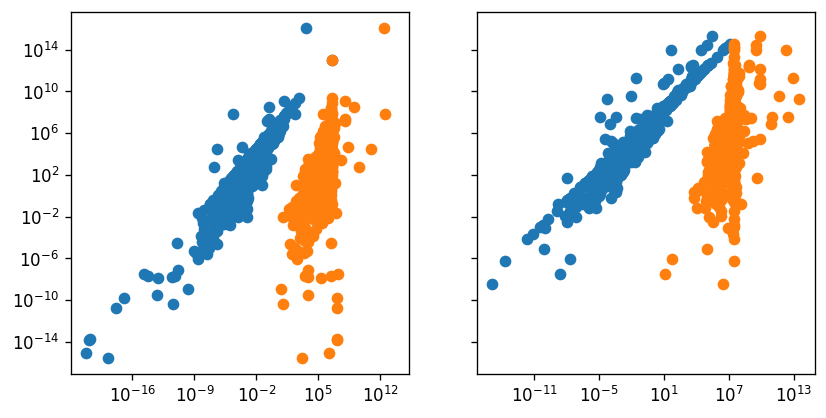

In [8]:
fig,axs = plt.subplots(1,2,figsize=(8,4),dpi=120,sharey=True)

beta = 1.0/0.15
B, K, D, N, u, s, Emin, sel = kio.load_ktn(path=data_path,beta=beta,Emax=None,Nmax=None,screen=True)
D = np.ravel(K.sum(axis=0))

Q = diags(D)-K.copy()

keep = np.zeros(sel.size,bool)
keep[Bind] = True

B_states = keep[sel]

keep = np.zeros(sel.size,bool)
keep[Aind] = True
A_states = keep[sel]

print(np.arange(N)[A_states]+1)
c=1
for b in np.arange(N)[B_states]:
    print(b+1,end=" ")
    if c%10==0:
        print(" ")
    c+=1

BF = beta*u-s
    
    
rho = np.exp(-BF) 
    

rho_A = rho.copy()
rho_B = rho.copy()
rho_A[~A_states] = 0.0
rho_B[~B_states] = 0.0
rho_A = rho_A[~B_states]
rho_B = rho_B[~A_states]
rho_A /= rho_A.sum()
rho_B /= rho_B.sum()
rho = [rho_A,rho_B]
sel = [~B_states,~A_states]

for j in range(2):
    x = spsolve(Q[sel[j],:][:,sel[j]],rho[j])
    y = spsolve(Q[sel[j],:][:,sel[j]],x)
    
    z = spsolve(Q[sel[j],:][:,sel[j]].transpose(),np.ones(rho[j].size)) # GT tau from each state
    
    
    
    #z = 2.0/D[sel[j]] * x
    axs[j].loglog(x,z*x,'o')
    axs[j].loglog(z,z*x,'o')
    
    
    
    
    print("T=",1.0/beta,"tau:",x.sum(),"tau^2:", 2.0*y.sum()/1.0e16, 2.0*(z*x).sum()/1.0e16, )

print("David:\n  29649201.19, 0.6875005231E+0016\n3142186.826, 0.2245162179E+0017")

In [11]:

betar = np.linspace(0.01,1.0/0.15,40)#arange(1,9)
tau = np.zeros((betar.size,8))
for i in range(betar.size):
    
    B, K, D, N, u, s, Emin, sel = kio.load_ktn(path=data_path,beta=betar[i],Emax=None,Nmax=None,screen=(i==0))
    
    #beta, B, K, D, N, u, s, kt, kcon, Emin, sel = load_save_mat(path=data_path,beta=betar[i],Emax=None,Nmax=None,generate=generate)
    D = np.ravel(K.sum(axis=0))
    
    Q = diags(D)-K.copy()
    
    keep = np.zeros(sel.size,bool)
    keep[Bind] = True
    
    B_states = keep[sel]
    
    keep = np.zeros(sel.size,bool)
    keep[Aind] = True
    A_states = keep[sel]
    
    
    if i==0:
        print("N_A: %d, N_B: %d" % (A_states.sum(),B_states.sum()))
    
    BF = betar[i]*u-s
    
    
    rho = np.exp(-BF) 
    
    
    rho_A = rho.copy()
    rho_B = rho.copy()
    rho_A[~A_states] = 0.0
    rho_B[~B_states] = 0.0
    rho_A = rho_A[~B_states]
    rho_B = rho_B[~A_states]
    rho_A /= rho_A.sum()
    rho_B /= rho_B.sum()
    rho = [rho_A,rho_B]
    sel = [~B_states,~A_states]
    
    
    inter_region = ~(B_states + A_states)
    rB, rtau, full_rK = gt.GT(rm_vec=inter_region,B=B,tau=1.0/D,block=50,rates=True,Ndense=50)
    rD, rN = 1.0/rtau, ratu.size
    r_A_states = A_states[~inter_region]
    r_B_states = B_states[~inter_region]
    r_BF = BF[~inter_region]
    
    r_rho = np.exp(-r_BF) 
    r_rho_A = r_rho.copy()
    r_rho_B = r_rho.copy()
    r_rho_A = r_rho_A[~r_B_states]
    r_rho_B = r_rho_B[~r_A_states]
    r_rho_A /= r_rho_A.sum()
    r_rho_B /= r_rho_B.sum()
    r_rho = [r_rho_A,r_rho_B]
    r_sel = [~r_B_states,~r_A_states]
    
    
    
    for j in range(2):
        x = spsolve(Q[sel[j],:][:,sel[j]],rho[j])
        y = spsolve(Q[sel[j],:][:,sel[j]],x)
        print("T=",1.0/betar[i],"tau:",x.sum(),"tau^2:",2.0*y.sum())
        tau[i][2*j+0] = x.sum()
        tau[i][2*j+1] = np.sqrt(2.0*y.sum()-tau[i][2*j]**2)
        """
        nu,v,w = spla.eig(Q.todense()[sel[j],:][:,sel[j]],left=True,right=True)
        nu = nu.real
        v = v.real
        w = w.real
        
        for nui in range(nu.size):
            www = w[:,nui].sum() * (v[:,nui]*rho[j]).sum() / np.dot(w[:,nui],v[:,nui])
            
            tau[i][4+2*j+0] += www / nu[nui]
            
            tau[i][4+2*j+1] += 2.0 * www / nu[nui] / nu[nui]
        
        tau[i][4+2*j+1] = np.sqrt(tau[i][4+2*j+1]-tau[i][4+2*j+0]**2)
        
        """
        
        x = spsolve(full_rK[r_sel[j],:][:,r_sel[j]],r_rho[j])
        y = spsolve(full_rK[r_sel[j],:][:,r_sel[j]],x)
        
        tau[i][4+2*j+0] = x.sum()
        tau[i][4+2*j+1] = np.sqrt(2.0*y.sum()-tau[i][4+2*j]**2)
        
#    pbar.update(1)
#pbar.close()
        
    



Connected Clusters: 1620, 1st 400 states in largest cluster: 0
cc: N: 4000->900 (4000,) (4000,)
N_A: 5, N_B: 128
T= 100.0 tau: 188214.37271172708 tau^2: 58694990409094.305
T= 100.0 tau: 7334.133010867617 tau^2: 311867485.5084757
T= 5.53453169347209 tau: 189233.98309140917 tau^2: 75690990706720.0
T= 5.53453169347209 tau: 7267.892531087437 tau^2: 273197861.26850456
T= 2.8460228654828503 tau: 190045.7778657416 tau^2: 97532581440975.69
T= 2.8460228654828503 tau: 7288.928441366431 tau^2: 246488450.45105052
T= 1.9155206286836932 tau: 191803.68176665288 tau^2: 126334005468375.2
T= 1.9155206286836932 tau: 7394.323954459202 tau^2: 229317905.91726348
T= 1.4435533621221466 tau: 195728.4245217292 tau^2: 165496991689127.2
T= 1.4435533621221466 tau: 7583.0803719296855 tau^2: 220006082.54123038
T= 1.158186497723223 tau: 202776.28209166118 tau^2: 220143389182812.9
T= 1.158186497723223 tau: 7855.681408381504 tau^2: 217453721.37931794
T= 0.967022067939499 tau: 213278.0547825158 tau^2: 297336597502547.44

# Plot

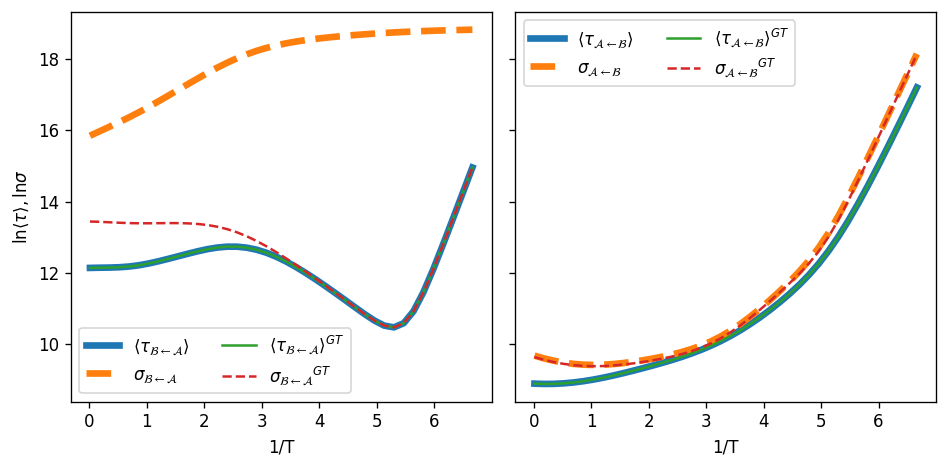

In [12]:
#"\sqrt{\langle\tau^2_{\mathcal{B\leftarrow A}}\rangle-\langle\tau_{\mathcal{B\leftarrow A}}\rangle^2}$",\
fig,axs = plt.subplots(1,2,figsize=(8,4),dpi=120,sharey=True)
labs = [r"$\langle\tau_{\mathcal{B\leftarrow A}}\rangle$",
        r"$\sigma_{\mathcal{B\leftarrow A}}$",\
        r"$\langle\tau_{\mathcal{A\leftarrow B}}\rangle$",\
        r"$\sigma_{\mathcal{A\leftarrow B}}$"]
for k in range(2):
    axs[k].plot((betar),np.log(tau[:,2*k]),'-',label=labs[2*k],lw=4)
    axs[k].plot((betar),np.log(tau[:,2*k+1]),'--',label=labs[2*k+1],lw=4)

for k in range(2):
    axs[k].plot((betar),np.log(tau[:,4+2*k]),'-',label=labs[2*k]+r"$^{GT}$")
    axs[k].plot((betar),np.log(tau[:,4+2*k+1]),'--',label=labs[2*k+1]+r"$^{GT}$")

axs[0].legend(ncol=2)
axs[1].legend(ncol=2)
axs[0].set_ylabel(r"$\ln\langle\tau\rangle,\ln\sigma$")
axs[0].set_xlabel("1/T")
axs[1].set_xlabel("1/T")
plt.tight_layout()
plt.savefig("finally_agreement.pdf")

7.0
6.126657403184979e-15


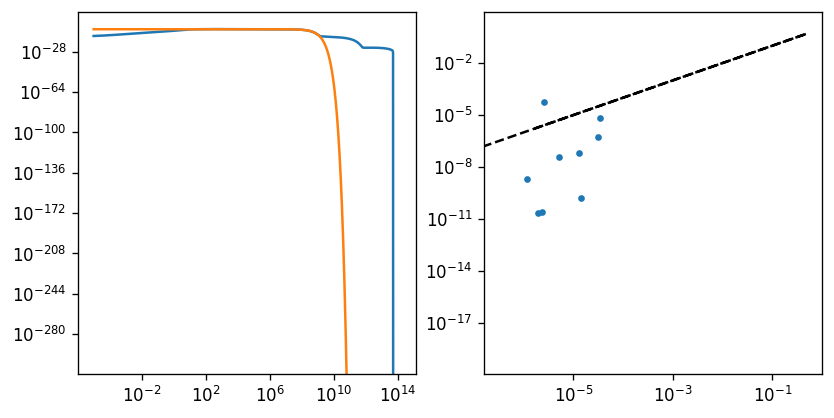

In [13]:
beta = 7.0

B, K, D, N, u, s, Emin, sel = kio.load_ktn(path=data_path,beta=beta,Emax=None,Nmax=None)

D = np.ravel(K.sum(axis=0))

BF = beta*u-s

keep = np.zeros(sel.size,bool)
keep[Aind] = True
B_states = keep[sel]

keep = np.zeros(sel.size,bool)
keep[Bind] = True
A_states = keep[sel]

inter_region = ~A_states + ~B_states

Q = (np.diag(D)-K.todense())[~B_states,:][:,~B_states]
print(beta)
rho = np.exp(-BF)
rho[~A_states] = 0.0
rho = rho[~B_states]
rho /= rho.sum()

nu,v,w = spla.eig(Q,left=True,right=True)
nu = nu.real
v = v.real
w = w.real
print(nu.min())

t = np.exp(np.linspace(np.log(.00001),np.log(1.0/nu.min()),1000))
tau = 0.0
p = np.zeros(t.size)
for i in range(nu.size):
    www = w[:,i].sum() * (v[:,i]*rho).sum() / np.dot(w[:,i],v[:,i])
    p += www * nu[i] * np.exp(-nu[i]*t)
    tau += www / nu[i]

fig,axs = plt.subplots(1,2,figsize=(8,4),dpi=120)

axs[0].plot(t,p,'-')
axs[0].plot(t,np.exp(-t/tau)/tau,'-')


axs[1].plot(rho/rho.sum(),w[:,nu.argmin()]/w[:,nu.argmin()].sum(),'.')
axs[1].plot(rho/rho.sum(),rho/rho.sum(),'k--')

axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[1].set_yscale("log")
axs[1].set_xscale("log")
    

# Graph transformation to remove intermediate states

In [15]:


# NB "full_rK" is in fact equal to D-K=(1-B).D in earlier notation - this is done 

rB, rtau, full_rK = gt.GT(rm_vec=inter_region,B=B,tau=1.0/D,block=1,rates=True,Ndense=50,screen=True)
rD, rN = 1.0/rtau, rtau.size
r_A_states = A_states[~inter_region]
r_B_states = B_states[~inter_region]
r_BF = BF[~inter_region]

oneA = np.ones(r_A_states.sum())
oneB = np.ones(r_B_states.sum())
r_BF = BF[~inter_region]
rDSS = D[~inter_region]





  5%|▍         | 44/900 [00:00<00:03, 232.39it/s]

GT regularization removing 900 states:


GT BECAME DENSE AT N=49, density=0.461058
casting to csr_matrix
GT done, 0 rescans due to LinAlgError


In [43]:
print(r_A_states.shape)

(133,)


# Eigendecomposition of GT matrix and evaluation of $k^{QSD}, k^{SS}, k^{NSS}$

## We also perform same eigendecomposition following additional GT to group all target states

## This is analytically identical, but in practice is numerically beneficial

6640828.056449447
[6640852.13111148 6640001.34261281 6427161.67952823 6596169.26843645 6391813.50625323]
[            inf             inf -1.07179228e+21 -1.16363431e+21 -2.34563453e+20]
29878480.195566967
[2.96276776e+07 2.96276698e+07 2.94854232e+07 2.95380854e+07 2.96276259e+07 2.94855428e+07 2.94854267e+07 2.94856754e+07 2.94899255e+07 2.94886230e+07
 2.94856815e+07 2.94856536e+07 2.94830481e+07 2.94856052e+07 1.55096706e+07 2.94861299e+07 2.98439215e+07 2.94861939e+07 2.94861266e+07 2.94874786e+07
 2.94899349e+07 2.96711571e+07 2.94868872e+07 3.43353811e+09 2.95001623e+07 6.63441894e+08 2.94855771e+07 2.94855993e+07 2.94850013e+07 2.94850060e+07
 2.94857426e+07 2.96278019e+07 6.21159346e+07 7.38338020e+08 2.98439251e+07 2.96275623e+07 3.03092316e+07 2.94976907e+07 3.14979490e+07 2.94858663e+07
 2.94849977e+07 8.82383702e+07 2.94887019e+07 3.15265057e+07 3.17606111e+07 2.96774156e+07 2.94860923e+07 2.94862565e+07 2.94854302e+07 2.94908786e+07
 2.94906704e+07 2.94858974e+07 2.948589

/Users/deepti/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/deepti/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/deepti/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/deepti/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/deepti/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/deepti/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/deepti/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/deepti/miniconda3/lib/python3.6/si

/Users/deepti/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/deepti/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/deepti/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/deepti/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/deepti/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/deepti/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/deepti/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/deepti/miniconda3/lib/python3.6/si

/Users/deepti/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/deepti/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/deepti/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/deepti/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/deepti/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/deepti/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/deepti/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/deepti/miniconda3/lib/python3.6/si

[-2.16228454e+22             inf             inf -2.22814712e+22             inf             inf             inf             inf -1.61864594e+23
  1.45019644e+22             inf             inf             inf             inf             inf             inf             inf  6.29530066e+23
             inf             inf -2.50832050e+23 -3.41162887e+23  9.66390946e+22  1.66282662e+24 -6.82367167e+21  6.52060533e+24             inf
  5.27181769e+22             inf             inf  9.26680293e+22 -4.19320918e+21             inf             inf             inf             inf
  2.84098305e+22             inf             inf  5.71708566e+22             inf             inf  5.92011670e+22  8.84097816e+22 -6.46039808e+23
 -1.07574531e+24  4.38563719e+22  2.00820710e+23             inf  3.35003144e+22  3.93714354e+22             inf             inf             inf
             inf             inf             inf             inf             inf  7.05081445e+22  5.43993730e+22 -3.72370054e+23  

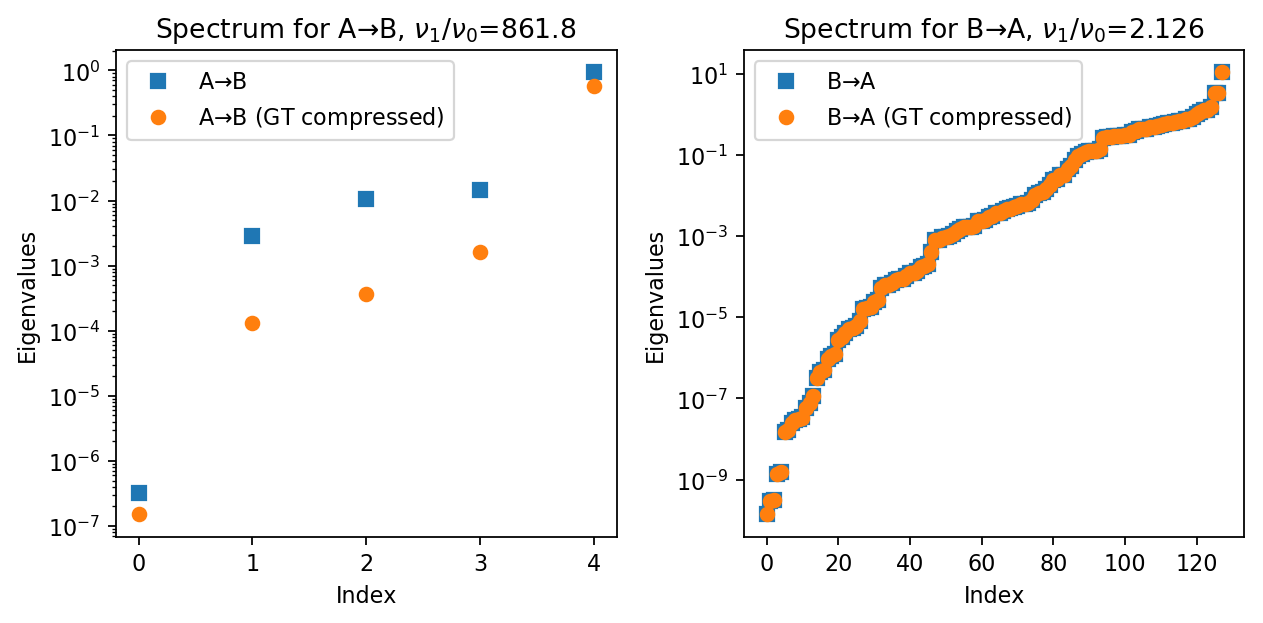

In [44]:
fig,ax = plt.subplots(1,2,figsize=(8,4),dpi=160)

kdata = [] # SS,NSS,QSD,nu
names=['A', 'B']
for i, r_s in enumerate([r_A_states,r_B_states]) :
    #r_S selects either A or B region in reduced (133,) state network
    #eigendecomposition of rate matrix in A or B region
    #for A, full_RK[r_A, :][:, r_A] is just a 5x5 matrix
    l, v = spla.eig(full_rK[r_s,:][:,r_s].todense())
    #order the eigenvalues from smallest to largest -- they are positive since Q = D - K instead of K-D
    qsdo = np.abs(l.real).argsort()
    nu = l.real[qsdo]
    #local equilibrium distribution in A/B
    rho = np.exp(-r_BF[r_s])
    rho /= rho.sum()
    #v[:, qsdo[0]] is the eigenvector corresponding to smallest eigenvalue
    #aka quasi=stationary distribution
    qsd = v[:,qsdo[0]]
    qsd /= qsd.sum()
    
    """
       Further GT compression of final states - differences are due to numerical issues
    """    
    rm_reg = np.zeros(rN,bool) 
    #~r_s selects out the non-A states, aka the B states
    #~r_s.nonzero()[0] returns an array of indices (5-132) of the B states
    #not sure why we couldn't have just done rm_reg[~r_s] = True to remove all B states
    rm_reg[(~r_s).nonzero()[0]] = True
    #remove all B states except for the lowest free energy minimum in B
    rm_reg[(~r_s).nonzero()[0][r_BF[~r_s].argmin()]] = False
    rrB, rrD, full_rrK, rrN, retry = gt_seq(N=rN,rm_reg=rm_reg,B=rB,D=rD,trmb=1,rates=True,Ndense=1)
    #remaining network only as 5 in A + 1 in B = 6 states
    rr_s = r_s[~rm_reg]
    rl, rv = spla.eig(full_rrK[rr_s,:][:,rr_s].todense())
    #order eigenvalues of reduced network
    rqsdo = np.abs(rl.real).argsort()
    rnu = rl.real[rqsdo]
    #new QSD
    qsd = rv[:,rqsdo[0]]
    qsd /= qsd.sum()
    
    #committor B<-A: probability of reaching B before A: 1_B.B_BA^I (eqn 6 of SwinburneW20)
    C = np.ravel(rrB[~rr_s,:][:,rr_s].sum(axis=0))
    #MFPT
    irrK = spla.inv(full_rrK[rr_s,:][:,rr_s].todense())
    tau = irrK.dot(rho).sum(axis=0)
    print(tau)
    #vector of T_Ba 's : in theory, could do another 5 GT's isolating each a in A
    #so that T_Ba = tau_a / P_Ba
    T_Ba = irrK.sum(axis=0)
    print(T_Ba)
    #compare to individual T_Ba quantities from GT-reduced 2-state networks
    T_Ba_GT = np.zeros(rr_s.sum())
    for a in range(rr_s.sum()):
        #remove all nodes in A except for a
        rm_reg = np.zeros(rrN, bool)
        rm_reg[rr_s] = True
        rm_reg[rr_s.nonzero()[0][a]] = False
        rfB, rfD, full_rfK, rfN, retry = gt_seq(N=rrN,rm_reg=rm_reg,B=rrB,D=rrD,trmb=1,rates=True,Ndense=1)
        rfB = rfB.todense()
        tau_Fs = 1./np.ravel(full_rfK.sum(axis=0))
        #remaining network only as 1 in A and 1 in B = 2 states
        rf_s = rr_s[~rm_reg]
        #tau_a^F / P_Ba^F
        T_Ba_GT[a] = tau_Fs[rf_s]/(rfB[~rf_s,:][:,rf_s])
    print(T_Ba_GT)   
    #MFPT_BA = (T_AB@rho)
    k_F = (rho/T_Ba).sum()
    
    """
        SS, NSS, QSD, nu, 1.K.qsd, kF, 1/tau
    """
    kSS = C.dot(np.diag(rDSS[r_s])).dot(rho)
    
    kNSS = C.dot(np.diag(rrD[rr_s])).dot(rho)
    
    kQSD = C.dot(np.diag(rrD[rr_s])).dot(qsd)
    
    oneKqsd = 0.0#(rrK[rr_s,:][:,rr_s].dot(qsd)).sum()
    
    kdata.append([kSS,kNSS,kQSD,rnu[0],oneKqsd,k_F,1.0/tau,qsd,rho])
    
    

       
    
    ax[i].set_title(r"Spectrum for %s$\to$%s, $\nu_1/\nu_0$=%4.4g" % (names[i],names[1-i],rnu[1]/rnu[0]))
    ax[i].set_ylabel("Eigenvalues")
    ax[i].set_xlabel("Index")
    ax[i].plot(nu,'s',label=r"%s$\to$%s" % (names[i],names[1-i]))
    ax[i].plot(rnu,'o',label=r"%s$\to$%s (GT compressed)" % (names[i],names[1-i]))
    ax[i].set_yscale("log")
    ax[i].legend()
plt.tight_layout()


# Check for numerical consistency

## We can show analytically that  $\nu_0 \equiv {\bf 1}_\mathcal{B}{\bf K}\,\hat{\pi}^{QSD}_\mathcal{B^I}$ = "1.K.qsd"

## and also $\nu_0 \equiv {\bf C}^\mathcal{A}_\mathcal{B}\, {\bf D}^\mathcal{I}_\mathcal{B}\, \hat{\pi}^{QSD}_\mathcal{B^I}=k^{QSD}$    =   "k_qsd"

## I find ${\bf 1}_\mathcal{B}{\bf K}\,\hat{\pi}^{QSD}_\mathcal{B^I}$ is the least reliable

## We also calculate $k^{SS}, k^{NSS}, k^F$ and $k^*=1/\langle\tau\rangle$, but these are not required to equal "kQSD"

## Results clearly show QSD for icosahedral basin is strongly non-Boltzmann ($k^{QSD}\neq k^{NSS}$)



	 A -> B

	 nu_0 = 1.506e-07

	 1.K.qsd =    0. Error to nu_0 = -100%

	 kQSD = 1.506e-07. Error to nu_0 = 4.2e-10%

	 kF = 1.506e-07. Error to nu_0 = -0.02327%

	 k*= 1.506e-07. Error to nu_0 = -0.02328%

	 kSS = 1.55e-07. Error to nu_0 = 2.917%

	 kNSS = 1.041e-07. Error to nu_0 = -30.86%

---QSD.max()=0.9909837708, rho.max()=0.9996337923 ------



	 B -> A

	 nu_0 = 1.379e-10

	 1.K.qsd =    0. Error to nu_0 = -100%

	 kQSD = 1.379e-10. Error to nu_0 = 2.365e-06%

	 kF = 3.397e-08. Error to nu_0 = 2.453e+04%

	 k*= 3.347e-08. Error to nu_0 = 2.416e+04%

	 kSS = 7.011e-08. Error to nu_0 = 5.072e+04%

	 kNSS = 1.999e-08. Error to nu_0 = 1.439e+04%

---QSD.max()=0.9958667204, rho.max()=0.4571613476 ------




/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')
/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


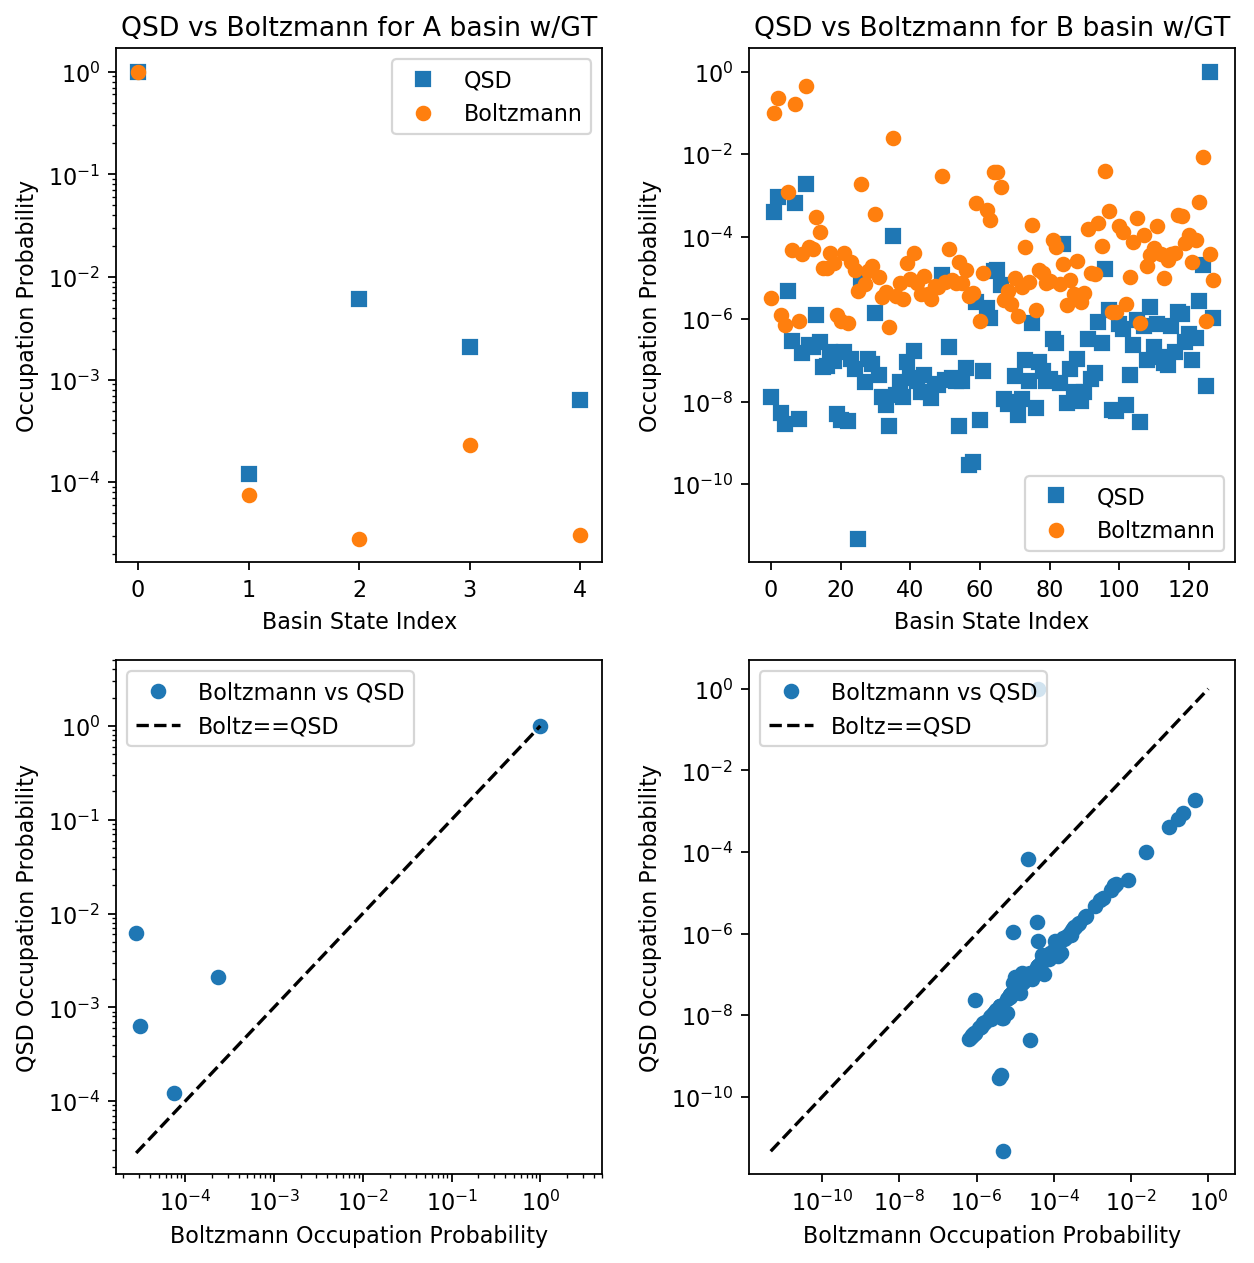

In [41]:
fig,ax = plt.subplots(2,2,figsize=(8,8),dpi=160)

for i in range(2):
    print("\n\t %s -> %s" % (names[i],names[1-i]))
    
    #     0: kSS, 1: kNSS, 2: kQSD, 3: nu, 4: 1.K.qsd, 5: k_F, 6: k* =1.0/tau
    
    print("\n\t nu_0 = %4.4g\n\n\t 1.K.qsd = %4.4g. Error to nu_0 = %4.4g%%" % \
          (kdata[i][3],kdata[i][4],(kdata[i][4]/kdata[i][3])*100.0-100.0))
    
    print("\n\t kQSD = %4.4g. Error to nu_0 = %4.4g%%" % \
          (kdata[i][2],(kdata[i][2]/kdata[i][3])*100.0-100.0))
    
    print("\n\t kF = %4.4g. Error to nu_0 = %4.4g%%" % \
          (kdata[i][5],(kdata[i][5]/kdata[i][3])*100.0-100.0))
    
    print("\n\t k*= %4.4g. Error to nu_0 = %4.4g%%" % \
          (kdata[i][6],(kdata[i][6]/kdata[i][3])*100.0-100.0))
    
    print("\n\t kSS = %4.4g. Error to nu_0 = %4.4g%%" % \
          (kdata[i][0],(kdata[i][0]/kdata[i][3])*100.0-100.0))
    
    print("\n\t kNSS = %4.4g. Error to nu_0 = %4.4g%%" % \
          (kdata[i][1],(kdata[i][1]/kdata[i][3])*100.0-100.0))
    
    print("\n---QSD.max()=%4.10g, rho.max()=%4.10g ------\n\n" % (kdata[i][-2].max(),kdata[i][-1].max()))
    
        
    
    ax[0,i].set_title(r"QSD and Boltzmann for %s basin w/GT" % (names[i]))
    ax[0,i].set_ylabel("Occupation Probability")
    ax[0,i].set_xlabel("Basin State Index")
    ax[0,i].plot(kdata[i][-2],'s',label=r"QSD")
    ax[0,i].plot(kdata[i][-1],'o',label=r"Boltzmann")
    ax[0,i].set_yscale("log")
    ax[0,i].legend()
    
    ax[0,i].set_title(r"QSD vs Boltzmann for %s basin w/GT" % (names[i]))
    ax[1,i].set_xlabel("Boltzmann Occupation Probability")
    ax[1,i].set_ylabel("QSD Occupation Probability")
    ax[1,i].plot(kdata[i][-1],kdata[i][-2],'o',label=r"Boltzmann vs QSD")
    
    pc = np.linspace(min(kdata[i][-2].min(),kdata[i][-1].min()),1.0,10,endpoint=True)
    ax[1,i].plot(pc,pc,'k--',label="Boltz==QSD")
    
    ax[1,i].set_yscale("log")
    ax[1,i].set_xscale("log")
    ax[1,i].set_xlim(xmax=5.0)
    ax[1,i].set_ylim(ymax=5.0)
    
    ax[1,i].legend()
    
plt.tight_layout()